# FSL Feat 1

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob, os
import subprocess as sp
import pandas as pd
from openpyxl import load_workbook

pd.set_option('display.max_rows', 300)
plt.rcParams["figure.figsize"] = (20,15)


---

In [2]:
study_path="/projects/niblab/experiments/bbx"

In [3]:
sub_ids=[x.split("/")[-1] for x in glob.glob(os.path.join("/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*"))]
sub_ids.sort()


less_runs=['sub-060', 'sub-002', 'sub-004', 'sub-031', 'sub-042', 'sub-048', 
           'sub-070', 'sub-073', 'sub-076', 'sub-079', 'sub-117', 'sub-128', 
           'sub-133', 'sub-146', 'sub-147', 'sub-148', 'sub-149', 'sub-156']


remove_subs=['sub-029', 'sub-047', 'sub-049', 'sub-069', 'sub-081', 'sub-094', 'sub-101',
             'sub-105', 'sub-106', 'sub-110', 'sub-113', 'sub-122', 'sub-125', 'sub-126', 
             'sub-139', 'sub-155', 'sub-158', 'sub-165']
sub_ids=[x for x in sub_ids if x not in remove_subs]

In [5]:
#sub_ids[1:]

## Generate `.fsf` files

In [5]:
def make_files(sub, main_dict, onset_path, preproc_dir, fsf_template):
    task = "training"
    sessions = ["ses-1"]#, "ses-2"]
    evs = ['SSBtaste', 'USBtaste', 'H2Otaste', 'H2Ocue', 'SSBcue', 'USBcue', 'rinse']

    all_runs = True

    #print("SUBJECT: %s \t TASK: %s \nPATH: %s"% (sub, task, sub_path))


    for sess_id in sessions:
        sess_path=os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s'%(sub, sess_id))
        #print(sess_path)
        if task == 'resting':
            # case for no runs, only task (i.e. resting)
            pass
        else:
        # 2 cases: individual/given runs or all runs found

            # case 1: if flag false, grab all available runs found
            if all_runs == True:
                #sub-001_ses-2_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold_brain.nii.gz
                funcs_found = glob.glob(os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s/func'%(sub, sess_id),
                                             "%s_%s_task-%s_run-*preproc_bold_brain.nii.gz" % (sub, sess_id, task)))
                runs=[x.split("/")[-1].split("_")[3].split("-")[1] for x in funcs_found]

                for func in funcs_found:
                    run=func.split("/")[-1].split("_")[3].split("-")[1]
                    x = int(run)

                    # SET OUTPUT PATH FOR FEAT DIRECTOR
                    output_path=os.path.join(study_path, 'data/preprocessed/subs_trimmed/%s/%s'%(sub, sess_id),
                                             'fsl_feat1', '%s_%s_task-%s_run-%s_method2'%(sub, sess_id,task, run))

                    #print("[OUTPUT PATH] ", output_path)


                    # SET CONFOUND
                    # sub-004_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_confound.txt
                    # %s_ses-%s_task-%s_run-%s_confound.txt
                    confound = os.path.join(preproc_dir, 'confounds_trimmed', "fmriprep_fd_spikes",
                                            '%s_%s_task-%s_run-%s_fd_spikes.txt'%(sub,sess_id, task, run))

                    scan = func.split(".")[0]
                    # TRS FROM NIFTI -- this value will always be 2, therefore we only run the check once
                    trs = sp.check_output(['fslval', '%s' % (scan), 'pixdim4', scan])
                    trs = trs.decode('utf-8')
                    trs = trs.strip('\n')

                    vol = sp.check_output(['fslnvols', scan])
                    vol = vol.decode('utf-8')
                    vol = vol.strip('\n')

                    with open(fsf_template, 'r') as infile:
                        tempfsf = infile.read()

                        #  fill in tempfsf file with parameters
                        tempfsf = tempfsf.replace("OUTDIR",output_path)
                        tempfsf = tempfsf.replace("FUNCTIONAL",scan)
                        tempfsf = tempfsf.replace("TR", trs)
                        tempfsf = tempfsf.replace("CONFOUND", confound)
                        tempfsf = tempfsf.replace("VOL",vol)


                        # SET MOTION PARAMETERS
                        for i in range(6):
                            motcor = os.path.join(preproc_dir, 'confounds_trimmed', 'basic_head_confounds',
                                                  '%s_%s_task-%s_run-%s_moco%s.tsv' % (sub, sess_id, task, run, i))
                            #main_dict[sub][run]['moco%i' % i] = motcor
                            moco_name=motcor.split("/")[-1].split(".")[0].split("_")[4]
                            tempfsf = tempfsf.replace(moco_name+"_file", motcor)


                            acompcor=os.path.join(preproc_dir, 'confounds_trimmed', 'acompcor',
                                          '%s_%s_task-%s_run-%s_a_comp_cor_0%s.txt' % (sub, sess_id, task, run, i))
                            tempfsf = tempfsf.replace("acompcor%s_file"%i, acompcor)





                        # SET EVS
                        # Loop through the given EVs and add the corresponding file to the dictionary

                        ctr = 0
                        for ev_name in evs:
                            # print(item)
                            ctr = ctr + 1

                            ev = os.path.join(onset_path, '%s_%s_task-%s_run-%s_trimmed.txt' % (sub,sess_id, ev_name, run))
                            #if ev_name == "H2O":
                             #   ev_name = "h2Otaste"
                            #if ev_name == "H2Ocue":
                             #   ev_name = "h2Ocue"

                            #print(ev_name)
                            #print('[EV%s] %s'%(ctr,ev))
                            #print('[EV NAME] 'ev_name)
                            tempfsf = tempfsf.replace(ev_name+"_file", ev)


                        fsf_outfile = '%s_%s_task-%s_run-%s_method2.fsf'%(sub, sess_id,task, run)#, today)
                        fsf_outpath = os.path.join(study_path, 
                                                   "data/preprocessed/subs_trimmed/%s/%s/fsl_feat1"%(sub, sess_id),
                                                   fsf_outfile)
                        #print("[FSF OUTFILE] ",fsf_outpath)
                        with open(fsf_outpath, 'w') as outfile: #os.path.join(outpath,
                            outfile.write(tempfsf)
                        outfile.close()
                    infile.close()

def bbx_feat1(subject="sub-001", all_subs=False):

    preproc_dir = "/projects/niblab/experiments/bbx/data/preprocessed"
    main_dict = {}
    fsf_template = os.path.join('/projects/niblab/experiments/bbx/data/feat_design_files/designMODEL1_method2.fsf')
    onset_path='/projects/niblab/experiments/bbx/data/onsets/trimmed_evs'

    #print('[FSL TEMPLATE] %s'%fsf_template)
    
    if all_subs==True:
        for subject in sub_ids:
            make_files(sub, main_dict, onset_path, preproc_dir, fsf_template)
    else:
        make_files(subject, main_dict, onset_path, preproc_dir, fsf_template)
        
        
           
    #print('[INFO] writing process complete for fsl feat1 fsf files.')



In [6]:
submission_list=sub_ids
for sub in submission_list:
    fsl_feat1_folder=os.path.join(study_path, 'data/preprocessed/subs_trimmed',
                                 sub, 'ses-1', 'fsl_feat1')
    if not os.path.exists(fsl_feat1_folder):
        os.makedirs(fsl_feat1_folder)
    
    bbx_feat1(sub)

## Submit Batch

In [7]:


def run_slurm(start, finish, batch_size, session, file_ext):

   
    bash_file = os.path.join('/projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1', 'feat1.job')

    shell_cmd = "sbatch --array={}-{}%{} {} {} {}".format(start, finish, batch_size, bash_file, session, file_ext)
    sp.run(shell_cmd, shell=True)
    print('[INFO] submitted: ', shell_cmd)
    #for sub_num in subject_set:
        #shell_cmd = ["sbatch", "--array=%s%1"%sub_num, "%s"%bash_file]

        #os.system(shell_cmd), '
        #print('[INFO] ', ' '.join(shell_cmd))


In [8]:
submission_list=sub_ids
file_ext="method2.fsf"


In [9]:
sub_ids[1:5]

['sub-002', 'sub-003', 'sub-004', 'sub-005']

In [10]:
#for x in submission_list:
#x=x.split("-")[1].lstrip('0')
start=2
finish=170
batch_size=150
session="ses-1"

run_slurm(start, finish, batch_size, session, file_ext)

[INFO] submitted:  sbatch --array=2-170%150 /projects/niblab/experiments/bbx/code/preprocessing/fsl_feat1/feat1.job ses-1 method2.fsf


## Quality Check

In [6]:

def feat1_qc(folder_tag):
    feat1_dfs=[]
    
    for session in ['ses-1']:#, "ses-2"]:
        
        feat1_dict={}
        folder_ct=len(glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/sub-*',
                                           '%s/fsl_feat1/sub-*_%s_task-training_run-*%s.feat'%(session,session, folder_tag))))
        print("[INFO] %s %s run folders found."%(folder_ct, session))
        
        sub_ids.sort()
        
        for sub_id in sub_ids:
            
            run_ct=0 # count training runs
            if sub_id not in feat1_dict:
                feat1_dict[sub_id]={}
            
            feat1_feats= glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/preprocessed/subs_trimmed/%s'%sub_id,
                                           '%s/fsl_feat1/sub-*_%s_task-training_run-*%s*/stats'%(session,session,folder_tag)))  


           
            run_ct=0
            for stats in feat1_feats:
                #print(stats)
                feat=stats.strip('\n')
                run_id=stats.split("/")[-2].split("_")[3].split(".")[0]        
                zstat=os.path.join(stats,"zstat1.nii.gz")
                
                run_ct+=1
                #zstat_files=glob.glob(os.path.join(stats, 'zstat[0-9]*.nii.gz'))
                    
                
                
                cope_files=glob.glob(os.path.join(stats, 'cope[0-9]*.nii.gz'))
                
                

                #feat1_dict[sub_id]['%s_zstat_file_ct'%run_id]=len(zstat_files)
                feat1_dict[sub_id]['%s_cope_file_ct'%run_id]=len(cope_files)
                
                #cp_ct=0
               
                #for cope in cope_files:
                 #   cope_id=cope.split("/")[-1].split(".")[0]
                  #  cp_ct+=1
                    # get activation
                    #cmd_out= sp.check_output(["fslstats", cope, '-m'])
                    #cmd_out=cmd_out.decode("utf-8")
                    
                    #feat1_dict[sub_id]["%s_%s_mean"%(run_id, cope_id)]=cmd_out.strip('\n')
                    #mu=cmd_out.split(" ")[0]
                    #std=cmd_out.split(" ")[1]
                    #feat1_dict[sub_id]["%s_zstat_mean"%(run_id)]=mu
                    #feat1_dict[sub_id]["%s_zstat_std"%(run_id)]=std
                    
                #else:
                    #feat1_dict[sub_id]["%s_zstat_mean"%(run_id)]=None
                    #feat1_dict[sub_id]["%s_zstat_std"%(run_id)]=None"""
                    #pass
                
            #feat1_dict[sub_id]['%s_cope_file_ct'%session]=cp_ct
            feat1_dict[sub_id]['run_ct']=run_ct
            
        feat1_df=pd.DataFrame(feat1_dict).T
        feat1_dfs.append((session, feat1_df))
        
    return feat1_dfs;

## Session-1 

**Method 1** 

In [8]:
feat1_dfs=feat1_qc('method2')

[INFO] 589 ses-1 run folders found.


In [11]:
s1_feat1_df=feat1_dfs[0][1]
s1_feat1_df.index.name = "patID"
#s2_feat1_df=feat1_dfs[1][1]
#s2_feat1_df.index.name = "patID"
s1_feat1_bad_df = s1_feat1_df[s1_feat1_df.isnull().any(axis=1)]
#s2_feat1_bad_df = s2_feat1_df[s2_feat1_df.isnull().any(axis=1)]
s1_feat1_df.sort_index(inplace=True)
#s2_feat1_df.sort_index(inplace=True)

In [12]:
len(list(s1_feat1_df.index.values))

149

In [13]:
s1_feat1_df.columns.values

array(['run-1_cope_file_ct', 'run-2_cope_file_ct', 'run-3_cope_file_ct',
       'run-4_cope_file_ct', 'run_ct'], dtype=object)

In [14]:
s1_feat1_df = s1_feat1_df.reindex(sorted(s1_feat1_df.columns), axis=1)

In [17]:
X=list(s1_feat1_df.loc[s1_feat1_df['run_ct']==2].index.values)
Y=list(s1_feat1_df.loc[s1_feat1_df['run_ct']==3].index.values)

In [18]:
print(X+Y)

['sub-052', 'sub-060', 'sub-002', 'sub-004', 'sub-048', 'sub-073', 'sub-076', 'sub-079', 'sub-128', 'sub-146', 'sub-147']


In [19]:
s1_feat1_df.style.highlight_null('red')

,run-1_cope_file_ct,run-2_cope_file_ct,run-3_cope_file_ct,run-4_cope_file_ct,run_ct
patID,,,,,
sub-001,17.000000,17.000000,17.000000,17.000000,4.000000
sub-002,17.000000,17.000000,17.000000,nan,3.000000
sub-003,17.000000,17.000000,17.000000,17.000000,4.000000
sub-004,17.000000,17.000000,nan,17.000000,3.000000
sub-005,17.000000,17.000000,17.000000,17.000000,4.000000
sub-006,17.000000,17.000000,17.000000,17.000000,4.000000
sub-007,17.000000,17.000000,17.000000,17.000000,4.000000
sub-008,17.000000,17.000000,17.000000,17.000000,4.000000
sub-009,17.000000,17.000000,17.000000,17.000000,4.000000


**Method 2**

In [84]:
feat1_method2_dfs=feat1_qc('method2')

[INFO] 582 ses-1 run folders found.


In [85]:
s1_feat1_m2=feat1_method2_dfs[0][1]
s1_feat1_m2.index.name = "patID"
#s2_feat1_df=feat1_dfs[1][1]
#s2_feat1_df.index.name = "patID"
s1_feat1_bad_m2 = s1_feat1_m2[s1_feat1_m2.isnull().any(axis=1)]
#s2_feat1_bad_df = s2_feat1_df[s2_feat1_df.isnull().any(axis=1)]
s1_feat1_m2.sort_index(inplace=True)
#s2_feat1_df.sort_index(inplace=True)

In [86]:
len(list(s1_feat1_m2.index.values))

149

In [87]:
s1_feat1_m2= s1_feat1_m2.reindex(sorted(s1_feat1_m2.columns), axis=1)

In [88]:
s1_feat1_m2.style.highlight_null('red')

,run-1_cope_file_ct,run-2_cope_file_ct,run-3_cope_file_ct,run-4_cope_file_ct,run_ct
patID,,,,,
sub-001,17.000000,17.000000,17.000000,17.000000,4.000000
sub-002,17.000000,17.000000,17.000000,nan,3.000000
sub-003,17.000000,17.000000,17.000000,17.000000,4.000000
sub-004,17.000000,17.000000,nan,17.000000,3.000000
sub-005,17.000000,17.000000,17.000000,17.000000,4.000000
sub-006,17.000000,17.000000,17.000000,17.000000,4.000000
sub-007,17.000000,17.000000,17.000000,17.000000,4.000000
sub-008,17.000000,17.000000,17.000000,17.000000,4.000000
sub-009,17.000000,17.000000,17.000000,17.000000,4.000000


---

---
---

In [61]:
from pandas import ExcelWriter

In [62]:
pathT='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-feat1_report.xlsx'

with pd.ExcelWriter(pathT, engine='xlsxwriter') as writer:    
    s1_feat1_df.to_excel(writer, 'ses-1_model1')   
    #s2_df_trim.to_excel(writer, 'ses-2_bids')   
    writer.save()  

In [46]:
bids_subs=glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/bids/bids_trimmed', 
                                 'sub-*'))

bids_subs=[x.split("/")[-1] for x in bids_subs]

In [47]:
fmriprep_subs=glob.glob(os.path.join('/projects/niblab/experiments/bbx/data/fmriprep/fmriprep_trimmed', 
                                 'sub-*'))

fmriprep_subs=[x.split("/")[-1] for x in fmriprep_subs if ".html" not in x.split("/")[-1] ]

In [48]:
[x for x in fmriprep_subs if x not in list(s1_feat1_df.index.values)]

[]

In [49]:
[x for x in bids_subs if x not in fmriprep_subs]

['sub-074', 'sub-094', 'sub-108']

In [50]:
print(list(s1_feat1_df.index.values))

['sub-001', 'sub-002', 'sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-007', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-012', 'sub-013', 'sub-014', 'sub-015', 'sub-016', 'sub-017', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-025', 'sub-026', 'sub-027', 'sub-028', 'sub-030', 'sub-031', 'sub-032', 'sub-033', 'sub-034', 'sub-035', 'sub-036', 'sub-037', 'sub-038', 'sub-039', 'sub-040', 'sub-041', 'sub-042', 'sub-043', 'sub-044', 'sub-045', 'sub-046', 'sub-048', 'sub-050', 'sub-051', 'sub-052', 'sub-053', 'sub-054', 'sub-055', 'sub-056', 'sub-057', 'sub-058', 'sub-059', 'sub-060', 'sub-061', 'sub-062', 'sub-063', 'sub-064', 'sub-065', 'sub-066', 'sub-067', 'sub-068', 'sub-070', 'sub-071', 'sub-072', 'sub-073', 'sub-075', 'sub-076', 'sub-077', 'sub-078', 'sub-079', 'sub-080', 'sub-082', 'sub-083', 'sub-084', 'sub-085', 'sub-086', 'sub-087', 'sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-095', 'sub-096', 'sub-097', 'sub-098'

---

## Session-2

Subjects with `nan` values 

In [64]:
#s2_feat1_bad_df.style.highlight_null('red')

All subjects, subjects with `nan` highlighted

In [ ]:
s2_feat1_df.style.highlight_null('red')

---

In [24]:
path='/projects/niblab/experiments/bbx/data/quality_analysis/bbx-trimmed_report.xlsx'


In [25]:
writer = pd.ExcelWriter(path, engine = 'openpyxl')
book = load_workbook(path)
writer.book = book
s1_feat1_df.to_excel(writer, sheet_name="ses-1_feat1")
#s2_df.to_excel(writer, sheet_name="ses-2_fmriprep")
writer.save()
writer.close()

In [26]:
new_excel=pd.read_excel(path, sheet_name="ses-1_feat1")


In [27]:
new_excel.head()

,patID,run-4_cope_file_ct,run-4_cope1_mean,run-4_cope2_mean,run-4_cope3_mean,run-4_cope4_mean,run-4_cope5_mean,run-4_cope6_mean,run-4_cope7_mean,run-4_cope8_mean,...,run-3_cope12_mean,run-3_cope13_mean,run-3_cope14_mean,run-3_cope15_mean,run-3_cope16_mean,run-1_cope17_mean,run-2_cope17_mean,run-4_cope17_mean,run-3_cope17_mean,ses-1_cope_file_ct
0,sub-001,17.0,41.345301,37.011063,6.384902,41.984286,4.334238,-30.626161,34.960399,-4.353627,...,-2.695001,2.399049,-3.936486,-5.094049,-6.335534,-4.940643,-1.315183,-0.638985,1.241485,17
1,sub-002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
2,sub-003,17.0,18.472461,19.519152,-17.503614,14.059235,-1.046690,-37.022765,35.976075,-4.462705,...,-0.185602,-1.068138,-1.805646,0.882537,-0.737508,0.337266,5.575037,4.413227,1.620045,17
3,sub-004,17.0,16.965965,33.591780,6.834999,17.913703,-16.625816,-26.756781,10.130965,-2.948859,...,NaN,NaN,NaN,NaN,NaN,3.094433,1.091694,-0.947739,NaN,17
4,sub-005,17.0,28.673747,-18.495300,16.471535,23.579708,47.169047,34.966836,12.202211,5.257966,...,1.963568,-0.502583,-4.664245,2.466151,-4.161662,3.151686,3.367997,5.094038,6.627813,17


---

[INFO] design (.png) file taken from file: 
 /projects/niblab/experiments/bbx/data/preprocessed/subs/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2.feat/design.png


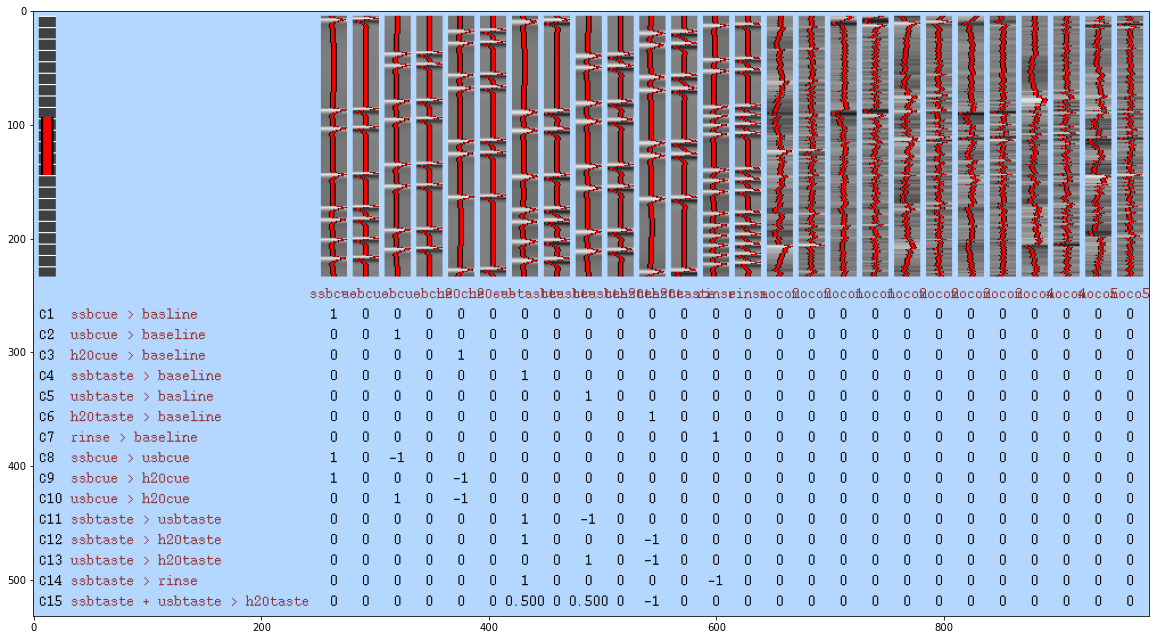

In [9]:
# displaym random design file sample

design_sample='/projects/niblab/experiments/bbx/data/preprocessed/subs/sub-001/ses-1/fsl_feat1/sub-001_ses-1_task-training_run-2.feat/design.png'

print('[INFO] design (.png) file taken from file: \n', 
      design_sample)


img = mpimg.imread(design_sample)
imgplot = plt.imshow(img)
plt.show()

